## Feed Forward Network 
Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In this notebook, we are focusing on creating a shallow consiting of 2 linear layers on which Relu and batch normalization is applied. 

After this we move forward to train our model on a deep network consisting of 4 linear layers on which Relu and Batch Normalization is applied. 

In [1]:
# Here we make all the imports
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm, trange
import seaborn as sns
import json
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pytorchtools

# Model Definitions

Below we have defined our shallow and Deep layers. We tried different models by increasing and decreasing the number of linear layers. We also tried different dropout values. The following experiment showed us that the best model is the a deep structiure with 4 layers. Moving beyond this we start overfitting 

In [4]:
input_dim = 200
hidden_1 = 1000
hidden_2 = 256
output_dim = 2

class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        #self.fc5 = nn.Linear(32, 2)
        #self.fc6 = nn.Linear(16, 2)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc6(x)
        output = F.log_softmax(x, dim=1)
        return output



The below function is used to divide the datasets into small chunks 

In [5]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

This code is used to import the Concat Embeddings of Images and Text and to load the Json files.

In [6]:
concat_embeddings = pd.read_csv("/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_50T_150I/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [7]:
train_data = pd.read_json("/content/drive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
batch_size = 32
chunked_data = split_dataframe(train_data, batch_size)

In [8]:
preds_train=[]
target_train =[]
preds_val=[]
target_val=[]

Code for training and validating the models 

In [9]:
def train(args, model, device, chunked_data, optimizer,criterion, concat_embeddings):
    model.train()

    for e in range(args['epochs']): 
      preds_train=[]
      target_train =[]
      avg_loss = 0.
      correct = 0
      total = 0
      for batch_idx, (data) in enumerate(chunked_data):
          id = data.id
          
          target = torch.Tensor(data.label.tolist()).to(device)
          a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
          if(len(a)==0):
            continue
          data = torch.Tensor(a).to(device)
          optimizer.zero_grad()
          output = model(data)

          loss = criterion(output, target.type(torch.cuda.LongTensor))
          avg_loss += loss.item()
          
          loss.backward()
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          #print(predicted.cpu().numpy())
          #print(target.cpu().numpy())
          # r= confusion_matrix(target.cpu().numpy(), predicted.cpu().numpy())
          p = predicted.cpu().numpy()
          t = target.cpu().numpy()
          
          preds_train.extend(p)
          target_train.extend(t)
         

          correct += (predicted.cpu() == target.cpu()).sum()
          optimizer.step()
      #print(preds_train)
      avg_loss /= len(chunked_data)
      print("Epoch : " + str(e)  + "  loss : " + str(avg_loss))
      precision, recall, f1, _ = precision_recall_fscore_support(preds_train, target_train, average='binary')
      r= confusion_matrix(preds_train, target_train)
      print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
      print("confusion_matrix")
      print(r)

      roc_auc = roc_auc_score(preds_train, target_train)
      print("roc",roc_auc)
      accuracy = 100.00 * correct.numpy() / total
      print("Epoch : " + str(e)  + "  accuracy : " + str(accuracy))


In [10]:
def post_train(args, model, device, chunked_data,criterion, concat_embeddings):
    model.eval()

    avg_loss = 0.
    correct = 0
    total = 0
    preds_val=[]
    target_val=[]
    for batch_idx, (data) in enumerate(chunked_data):
        id = data.id
        target = torch.Tensor(data.label.tolist()).to(device)
        a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
        if(len(a)==0):
          continue
        data = torch.Tensor(a).to(device)
        output = model(data)
        #print(output.shape,target.shape)


        loss = criterion(output, target.type(torch.cuda.LongTensor))
        avg_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted.cpu() == target.cpu()).sum()
        p = predicted.cpu().numpy()
        t = target.cpu().numpy()
        preds_val.extend(p)
        target_val.extend(t)

    avg_loss /= len(chunked_data)
    precision, recall, f1, _ = precision_recall_fscore_support(preds_val, target_val, average='binary')
    precision1, recall1, thresholds = precision_recall_curve(preds_val, target_val)
    r= confusion_matrix(preds_val, target_val)
    accuracy = 100.00 * correct.numpy() / total
    fpr, tpr, _ = roc_curve(target_val, preds_val)

    print( "  accuracy : " + str(accuracy))
    print("  loss : " + str(avg_loss))
    print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
    print("confusion_matrix")
    print(r)
    roc_auc = roc_auc_score(preds_val, target_val)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)

    for i in range(r.shape[0]):
      for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
    
    print("roc",roc_auc)
    #plt.figure(1)

    #sns.heatmap(r,annot=True)
    plt.show()


    pyplot.plot(recall1, precision1, marker='.', label='Shallow_net')
    # axis labels
    print("Precison Vs Recall")
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.title('Precision Vs Recall', fontsize=20)
    # show the plot
    pyplot.show()

    print("ROC")

    # plt.plot([0, 1], [0, 1], 'k–')
    plt.plot(fpr, tpr, label='FNN_ROC(area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()




# Shallow : Train

In [11]:

model_shallow = BNShallowNet().to('cuda')
args = {'lr': 0.1, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_shallow.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_shallow, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6258894032413574
 precision :0.4051010268300762 recall :0.5504050405040504 f1 0.46670482732303
confusion_matrix
[[4482 1796]
 [ 999 1223]]
roc 0.6321633357983776
Epoch : 0  accuracy : 67.11764705882354
Epoch : 1  loss : 0.5913685849846754
 precision :0.47068565750248426 recall :0.6093481989708405 f1 0.5311156793122781
confusion_matrix
[[4570 1598]
 [ 911 1421]]
roc 0.6751345404711531
Epoch : 1  accuracy : 70.48235294117647
Epoch : 2  loss : 0.5703514207406599
 precision :0.4988406757204372 recall :0.623860811930406 f1 0.5543898398674765
confusion_matrix
[[4573 1513]
 [ 908 1506]]
roc 0.6876287299875494
Epoch : 2  accuracy : 71.51764705882353
Epoch : 3  loss : 0.5502520858457214
 precision :0.5207022192779066 recall :0.6434711420384773 f1 0.5756133284511169
confusion_matrix
[[4610 1447]
 [ 871 1572]]
roc 0.702286999118958
Epoch : 3  accuracy : 72.72941176470589
Epoch : 4  loss : 0.5385008617339277
 precision :0.545876117919841 recall :0.6629123089300081 f1 0.59872842

# Shallow : Validation

Running the validation loss and accuarcy on the concat embeddings of dev seen and dev unseen csv

  accuracy : 45.370370370370374
  loss : 1.179232120513916
 precision :0.63 recall :0.3631123919308357 f1 0.46069469835466176
confusion_matrix
[[119  74]
 [221 126]]
roc 0.4898463514058323


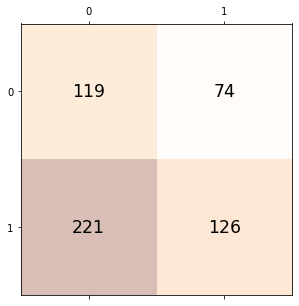

Precison Vs Recall


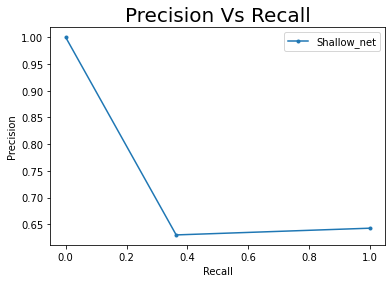

ROC


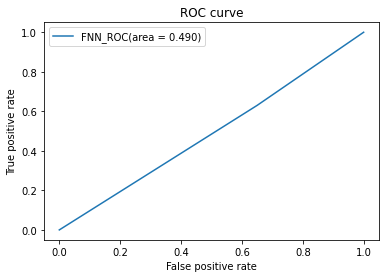

In [12]:

validation_paths = ["/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_50T_150I/ConcatEmbeddings_dev_unseen.csv"]
concat_embeddings_validation = pd.concat( map(pd.read_csv, validation_paths), ignore_index=True)
concat_embeddings_validation.head()
concat_embeddings_validation.rename(columns={"0": "id"}, inplace=True)
batch_size = 32
val_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_data_unseen = val_data_unseen[val_data_unseen.id.isin(concat_embeddings_validation.id)]
chunked_data_validation = split_dataframe(val_data_unseen, batch_size)


args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Shallow : Test Unseen


  accuracy : 41.5
  loss : 1.301728985139302
 precision :0.6533333333333333 recall :0.35 f1 0.45581395348837206
confusion_matrix
[[340 260]
 [910 490]]
roc 0.45833333333333337


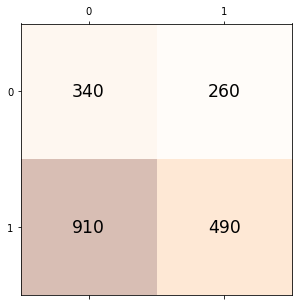

Precison Vs Recall


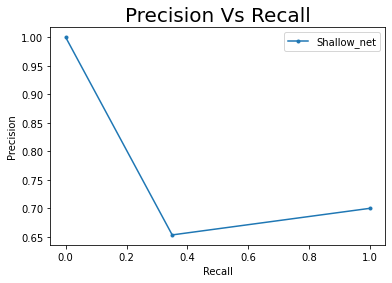

ROC


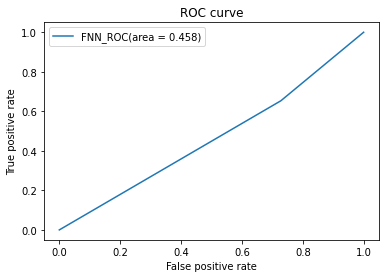

In [13]:
test_unseen_paths = ["/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_50T_150I/ConcatEmbeddings_test_unseen.csv"]

concat_embeddings_test_unseen = pd.concat( map(pd.read_csv, test_unseen_paths), ignore_index=True)
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_data_unseen = test_data_unseen[test_data_unseen.id.isin(concat_embeddings_test_unseen.id)]
chunked_data_test_unseen = split_dataframe(test_data_unseen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)

# Shallow: Test Seen

  accuracy : 55.0
  loss : 0.9348817020654678
 precision :0.6530612244897959 recall :0.5333333333333333 f1 0.5871559633027523
confusion_matrix
[[230 170]
 [280 320]]
roc 0.5541666666666666


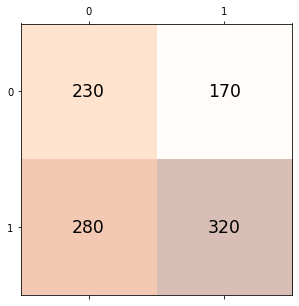

Precison Vs Recall


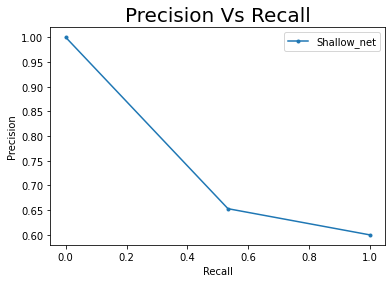

ROC


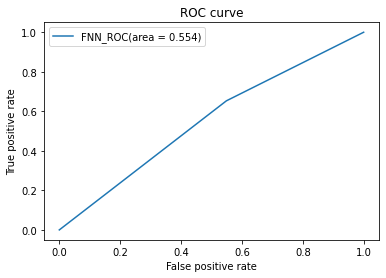

In [14]:
test_seen_paths = ["/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_50T_150I/ConcatEmbeddings_test_seen.csv"]

concat_embeddings_test_seen = pd.concat( map(pd.read_csv, test_seen_paths), ignore_index=True)
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_seen = pd.read_json("/content/drive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_data_seen = test_data_seen[test_data_seen.id.isin(concat_embeddings_test_seen.id)]
chunked_data_test_seen = split_dataframe(test_data_seen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model : Training

In [15]:
import json
model_deep = BNDeepNet().to('cuda')
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_deep.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_deep, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6784066972427798
 precision :0.1881417687976151 recall :0.37967914438502676 f1 0.2516057585825028
confusion_matrix
[[4553 2451]
 [ 928  568]]
roc 0.5148681273038783
Epoch : 0  accuracy : 60.247058823529414
Epoch : 1  loss : 0.6443153113350832
 precision :0.09837694600861212 recall :0.47368421052631576 f1 0.16291826659352715
confusion_matrix
[[5151 2722]
 [ 330  297]]
roc 0.5639728051234398
Epoch : 1  accuracy : 64.09411764705882
Epoch : 2  loss : 0.6262969751107065
 precision :0.10400794965220271 recall :0.5597147950089126 f1 0.1754189944134078
confusion_matrix
[[5234 2705]
 [ 247  314]]
roc 0.6094958910174931
Epoch : 2  accuracy : 65.27058823529411
Epoch : 3  loss : 0.6195595997168606
 precision :0.17323617091752236 recall :0.5482180293501048 f1 0.26327712056380564
confusion_matrix
[[5050 2496]
 [ 431  523]]
roc 0.6087233799016626
Epoch : 3  accuracy : 65.56470588235294
Epoch : 4  loss : 0.6137913657086236
 precision :0.2063597217621729 recall :0.5822429906542056 f

# Deep Model: Validation

  accuracy : 56.666666666666664
  loss : 0.7551125042578753
 precision :0.26 recall :0.37681159420289856 f1 0.3076923076923077
confusion_matrix
[[254 148]
 [ 86  52]]
roc 0.5043261951113995


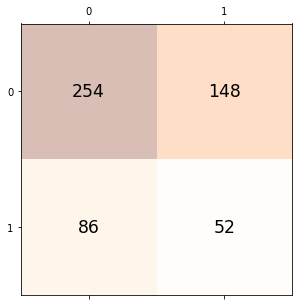

Precison Vs Recall


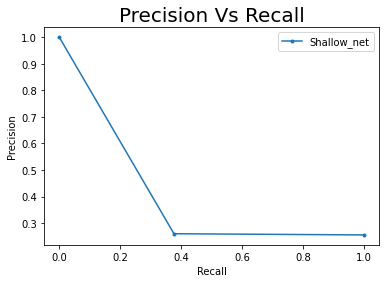

ROC


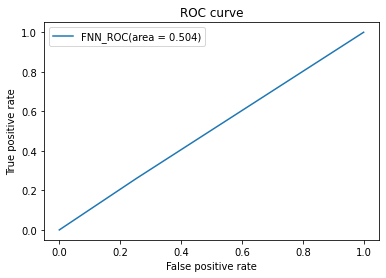

In [16]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Deep Model: Test Seen 

  accuracy : 52.9
  loss : 0.7743265246972442
 precision :0.21428571428571427 recall :0.5497382198952879 f1 0.3083700440528634
confusion_matrix
[[424 385]
 [ 86 105]]
roc 0.5369210258932557


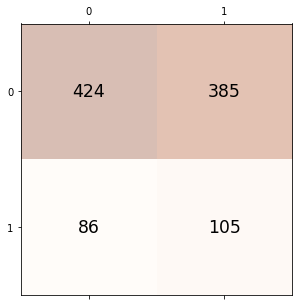

Precison Vs Recall


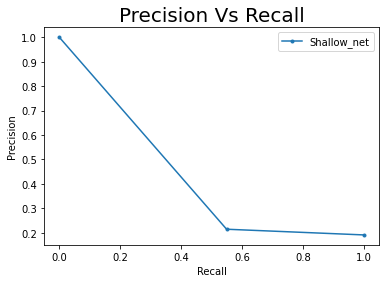

ROC


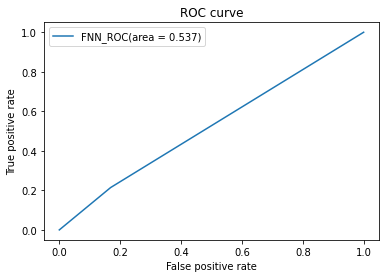

In [17]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model: Test UnSeen

  accuracy : 55.45
  loss : 0.7532534518885234
 precision :0.22933333333333333 recall :0.354639175257732 f1 0.2785425101214575
confusion_matrix
[[937 578]
 [313 172]]
roc 0.48656051172127524


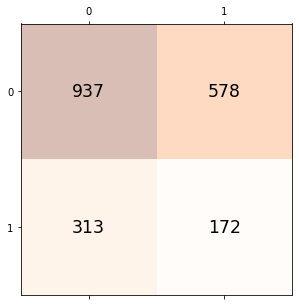

Precison Vs Recall


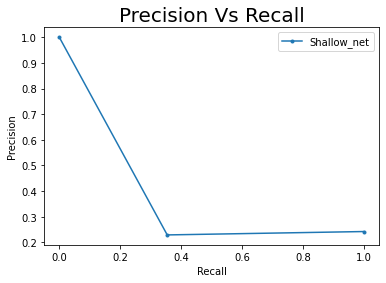

ROC


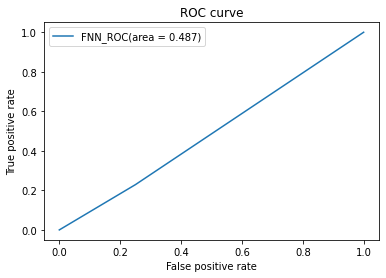

In [18]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)